# E2a: Küchentischversuch zum Laval-Rotor

Name:  David Büning
Datum:  9.01.2024

## Forschungsfrage

Wie kann man mithilfe eines Beschleunigungssensors die Frequenzen und Amplituden von schwingenden Objekten berechnen und sich ausgeben lassen? 

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="heimversuch1.jpg" width="500">

- Beschreibung des Aufbaus: Ich habe mein Handy auf den Tisch gelegt. Den Beschleunigungssensor habe ich mit Klebeband auf der Rückseite des Handys befestigt.
- Vorgangsbeschreibung: Mithilfe eines anderen Handys habe ich mein Handy angerufen. Während mein Handy vibriert hat habe ich den Messvorgang auf dem Pi laufen lassen.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_153110_DavidBuening_Handy" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240104_153110_DavidBuening_Handy.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_153110_DavidBuening_Handy/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_153110_DavidBuening_Handy/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_153110_DavidBuening_Handy/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
# ÜBER PATH NOCH UNCLEAN !!!
# Path definieren
path = "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_153110_DavidBuening_Handy/data_20240104_153110_DavidBuening_Handy.h5"
# hdf5 Datei als f öffnen
with h5py.File(path, 'r') as f:
    # in Raw Data und in Sensor Group gehen
    sensor_group = f['RawData']['1ee847be-fddd-6ee4-892a-68c4555b0981']
    # Zeit und Beschleunigungen als np array abspeichern
    time = np.array(sensor_group['timestamp'])
    acc_x = np.array(sensor_group['acceleration_x'])
    acc_y = np.array(sensor_group['acceleration_y'])
    acc_z = np.array(sensor_group['acceleration_z'])
# hdf5 Datei schließen        
f.close()

print(acc_x)
print(acc_y)
print(acc_z)
print(np.sqrt(1.216**2+10**2+0.47**2))

[-1.2160246 -1.0198916 -1.0198916 ... -0.1569064 -0.1569064 -0.1569064]
[10.002783   9.9635564  9.9635564 ... 10.0420096 10.0420096 10.0420096]
[0.4707192 0.0392266 0.0392266 ... 0.3530394 0.3530394 0.3530394]
10.0846197746866


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
acc_mean = get_vec_accel(acc_x, acc_y, acc_z)
print(acc_mean)

[10.08741593 10.01569637 10.01569637 ... 10.04943845 10.04943845
 10.04943845]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


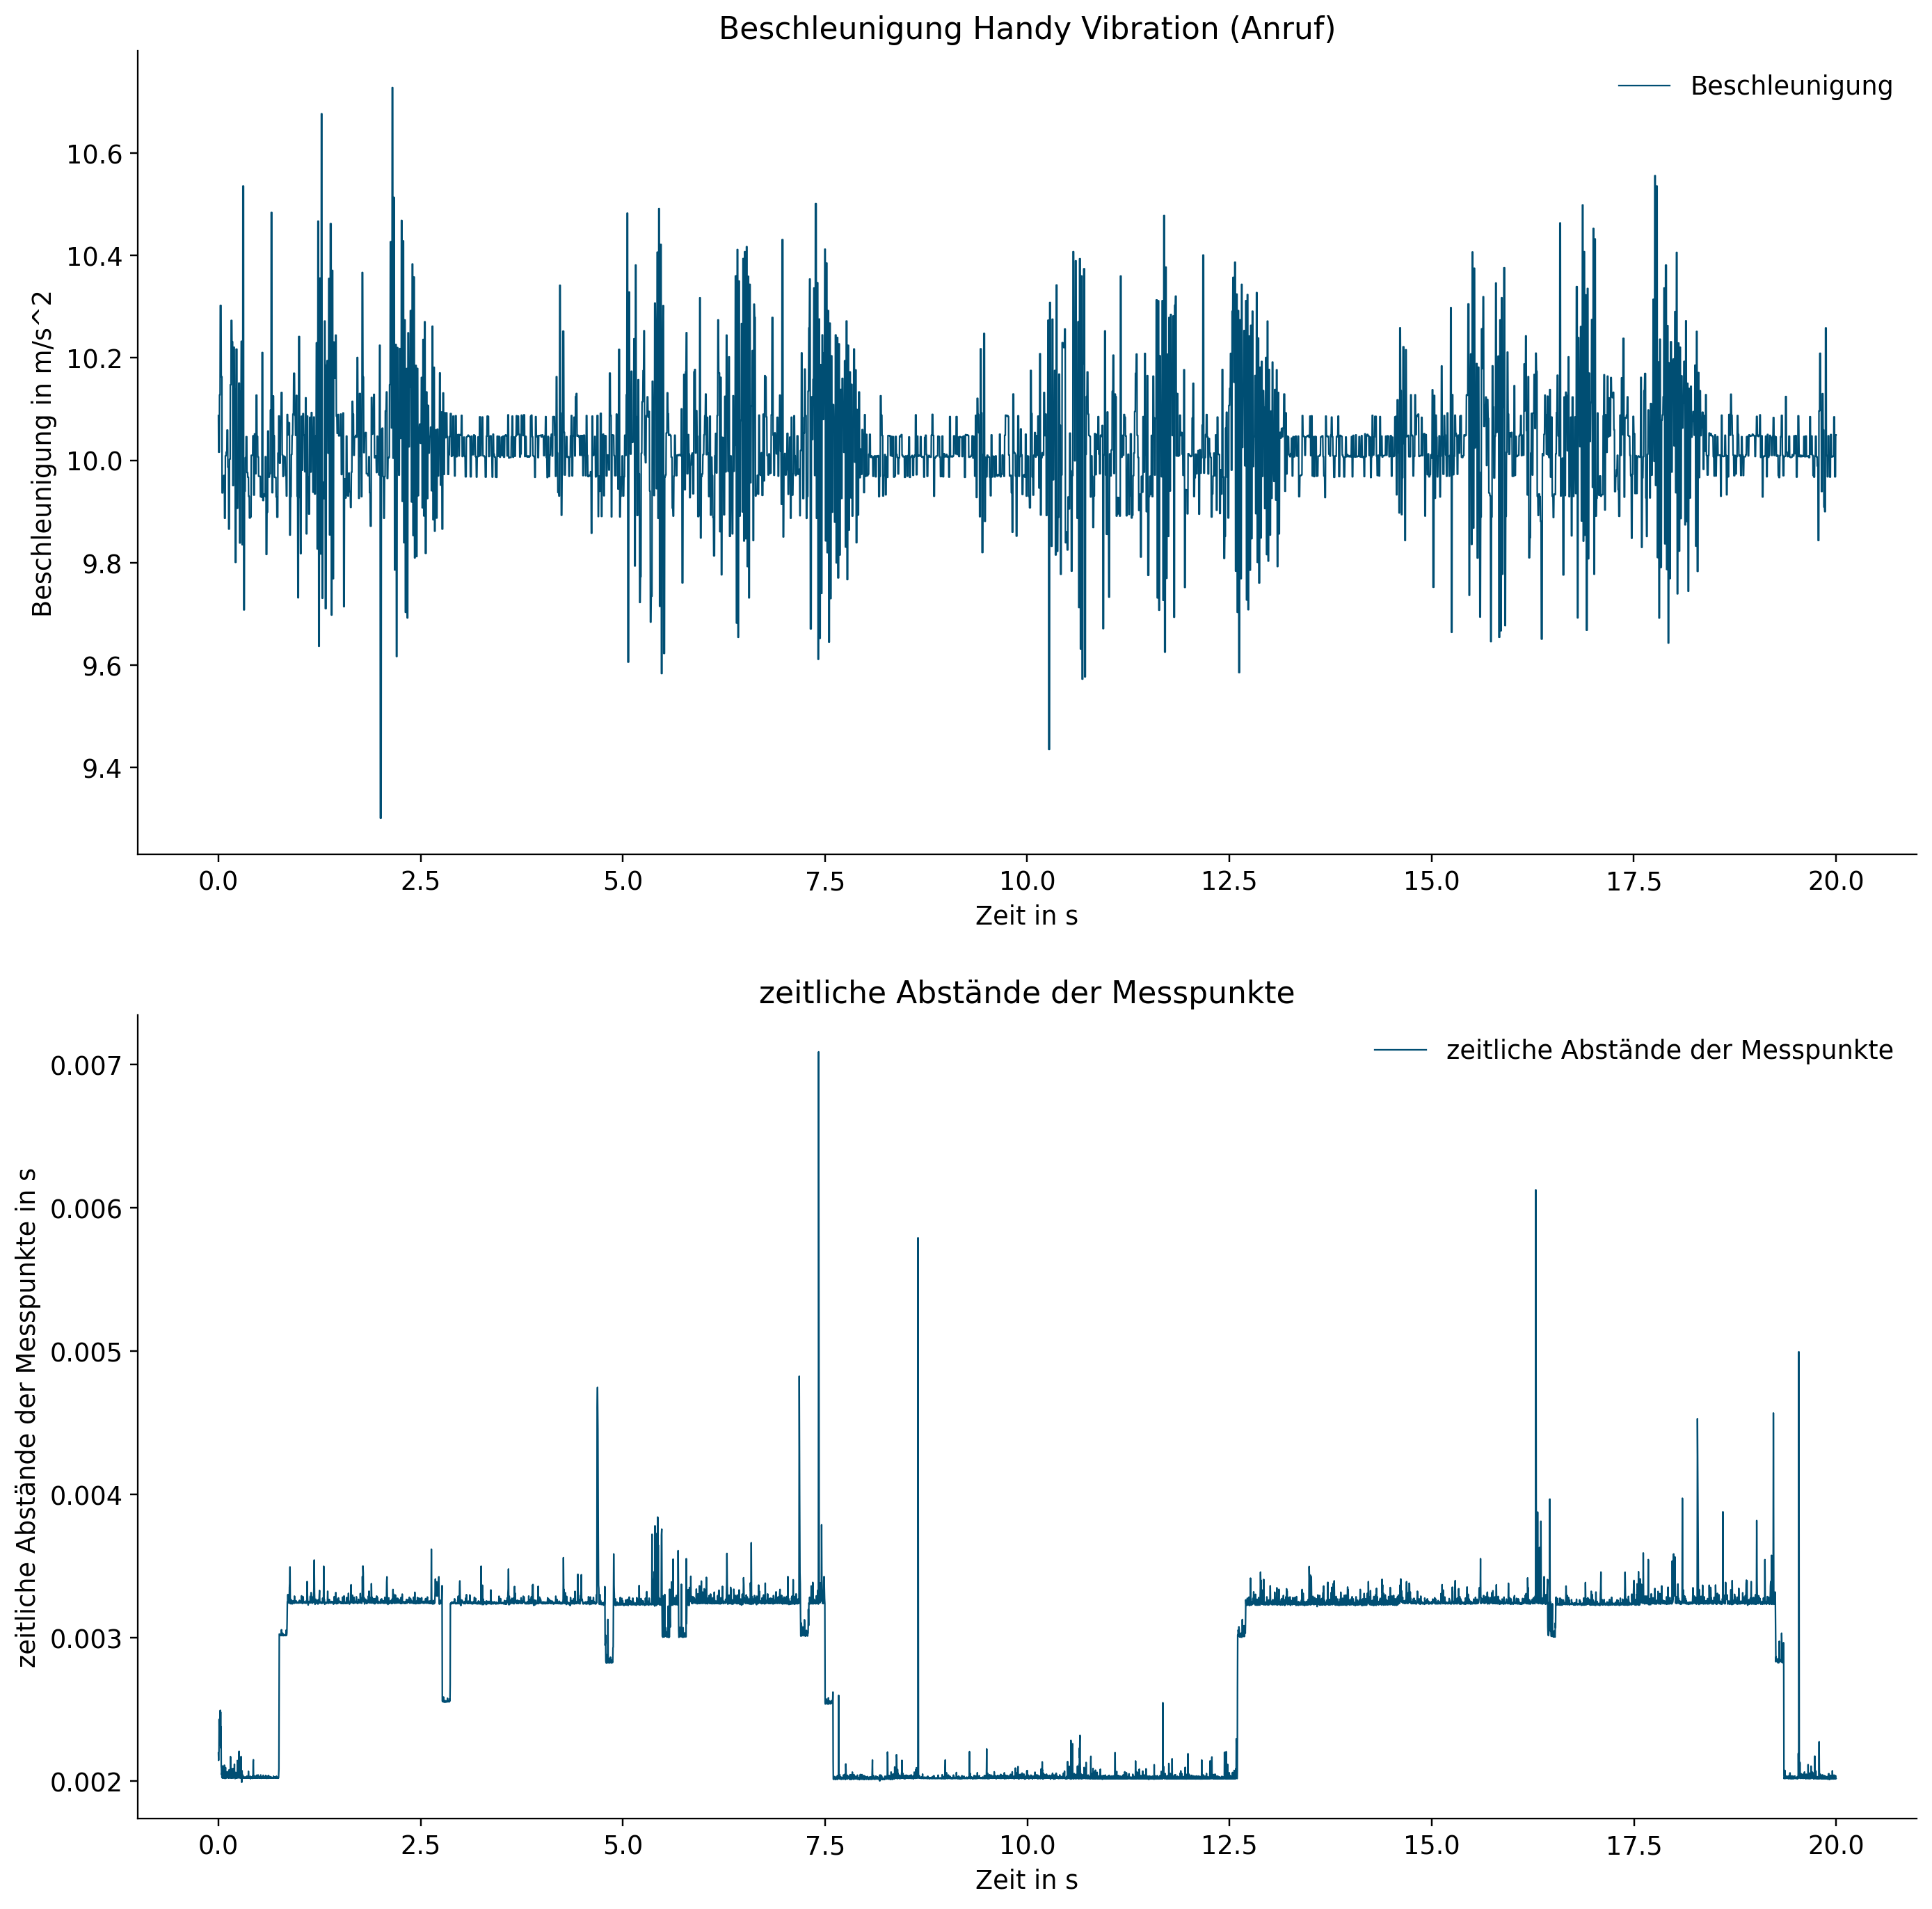

In [6]:
fig,axs = plt.subplots(2,1,figsize=(15, 15))

# Plot für die Beschleunigung erstellen
axs[0].plot(time, acc_mean, label='Beschleunigung')
axs[0].set_xlabel('Zeit in s')
axs[0].set_ylabel('Beschleunigung in m/s^2')
axs[0].set_title('Beschleunigung Handy Vibration (Anruf)')
axs[0].legend()

# Liste mit zeitlichen Abständen zwischen den Messpunkten berechnen
time_diff = np.diff(time)
# Plot für die zeitlichen Abstände erstellen
axs[1].plot(time[:-1], time_diff, label='zeitliche Abstände der Messpunkte')
axs[1].set_xlabel('Zeit in s')
axs[1].set_ylabel('zeitliche Abstände der Messpunkte in s')
axs[1].set_title('zeitliche Abstände der Messpunkte')
axs[1].legend()



#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
(new_time, new_acc_mean) = interpolation(time, acc_mean)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

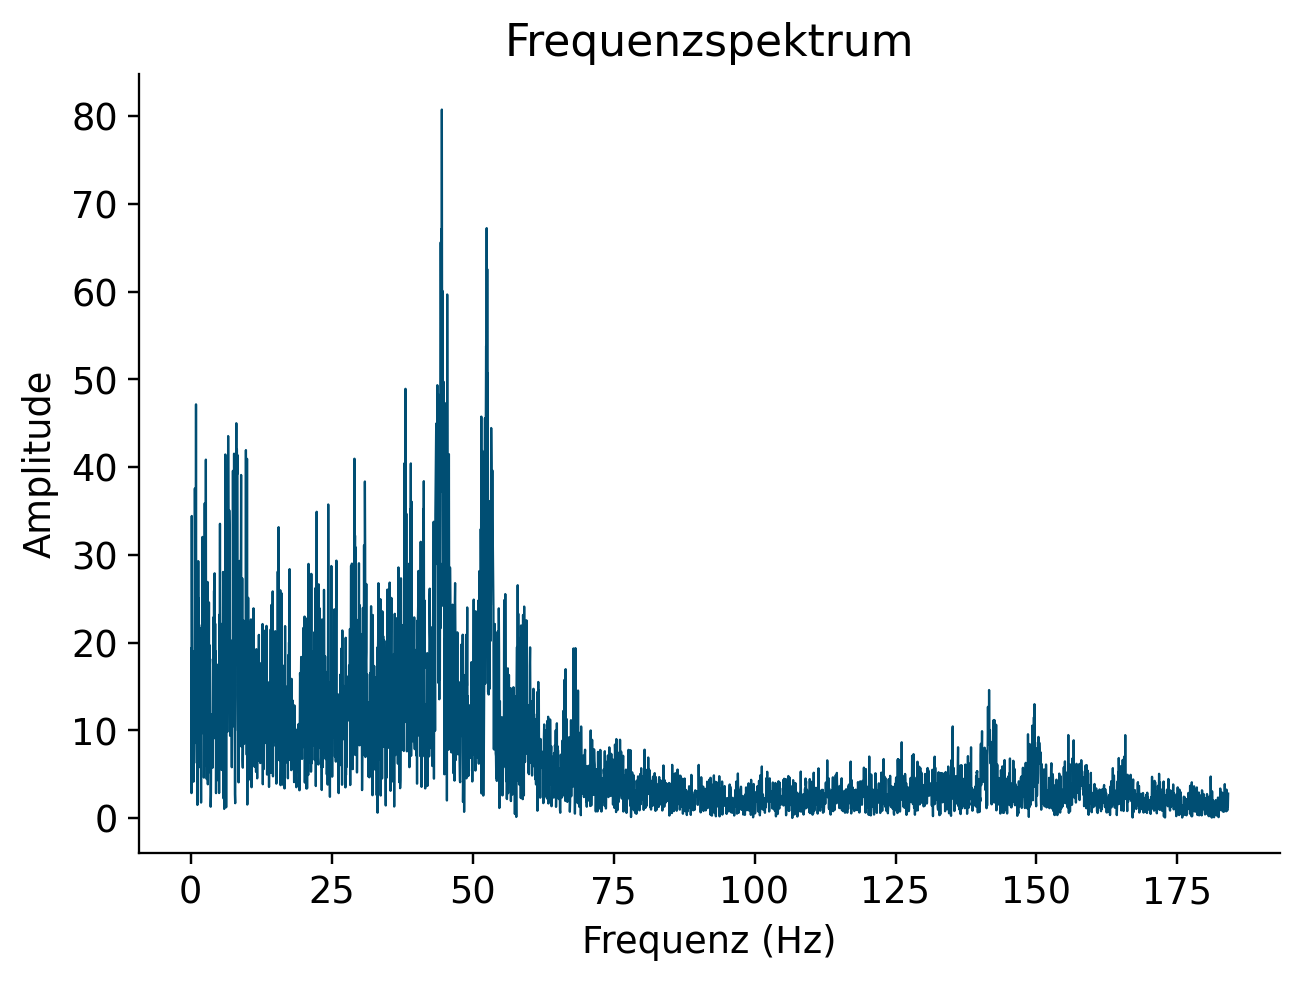

In [9]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
(amplituden, frequenzen) = my_fft(new_acc_mean, new_time)

plt.plot(frequenzen[1:], amplituden[1:])
plt.title('Frequenzspektrum')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="heimversuch2.jpg" width="500">

- Beschreibung des Aufbaus: Ich habe meinen Handmixer (ohne Aufsatz) auf den Tisch gelegt und an den Strom angeschlossen. Dann habe ich meinen Beschleunigungssensor wieder mit Klebeband auf der Oberfläche des Mixers befestigt.
- Vorgangsbeschreibung: Zuerst habe ich den Handmixer festgehalten. Dann habe ich die Taste für den Turbo Modus gedrückt und über den PI den Messvorgang ausgeführt. Während der ganzen Messung war der Mixer angeschaltet.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [12]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_154327_DavidBuening_Handmixer" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240104_154327_DavidBuening_Handmixer.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_154327_DavidBuening_Handmixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_154327_DavidBuening_Handmixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_154327_DavidBuening_Handmixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [13]:

# Path definieren
path = "/home/jovyan/work/lavalrotor_home_experiment/measurement_data/data_20240104_154327_DavidBuening_Handmixer/data_20240104_154327_DavidBuening_Handmixer.h5"
# hdf5 Datei als f öffnen
with h5py.File(path, 'r') as f:
    # in Raw Data und in Sensor Group gehen
    sensor_group = f['RawData']['1ee847be-fddd-6ee4-892a-68c4555b0981']
    # Zeit und Beschleunigungen als np array abspeichern
    time = np.array(sensor_group['timestamp'])
    acc_x = np.array(sensor_group['acceleration_x'])
    acc_y = np.array(sensor_group['acceleration_y'])
    acc_z = np.array(sensor_group['acceleration_z'])
# hdf5 Datei schließen        
f.close()

#### 2. Betrag der Beschleunigung berechnen


In [14]:
acc_mean = get_vec_accel(acc_x, acc_y, acc_z)

#### 3. Darstellung der Messdaten

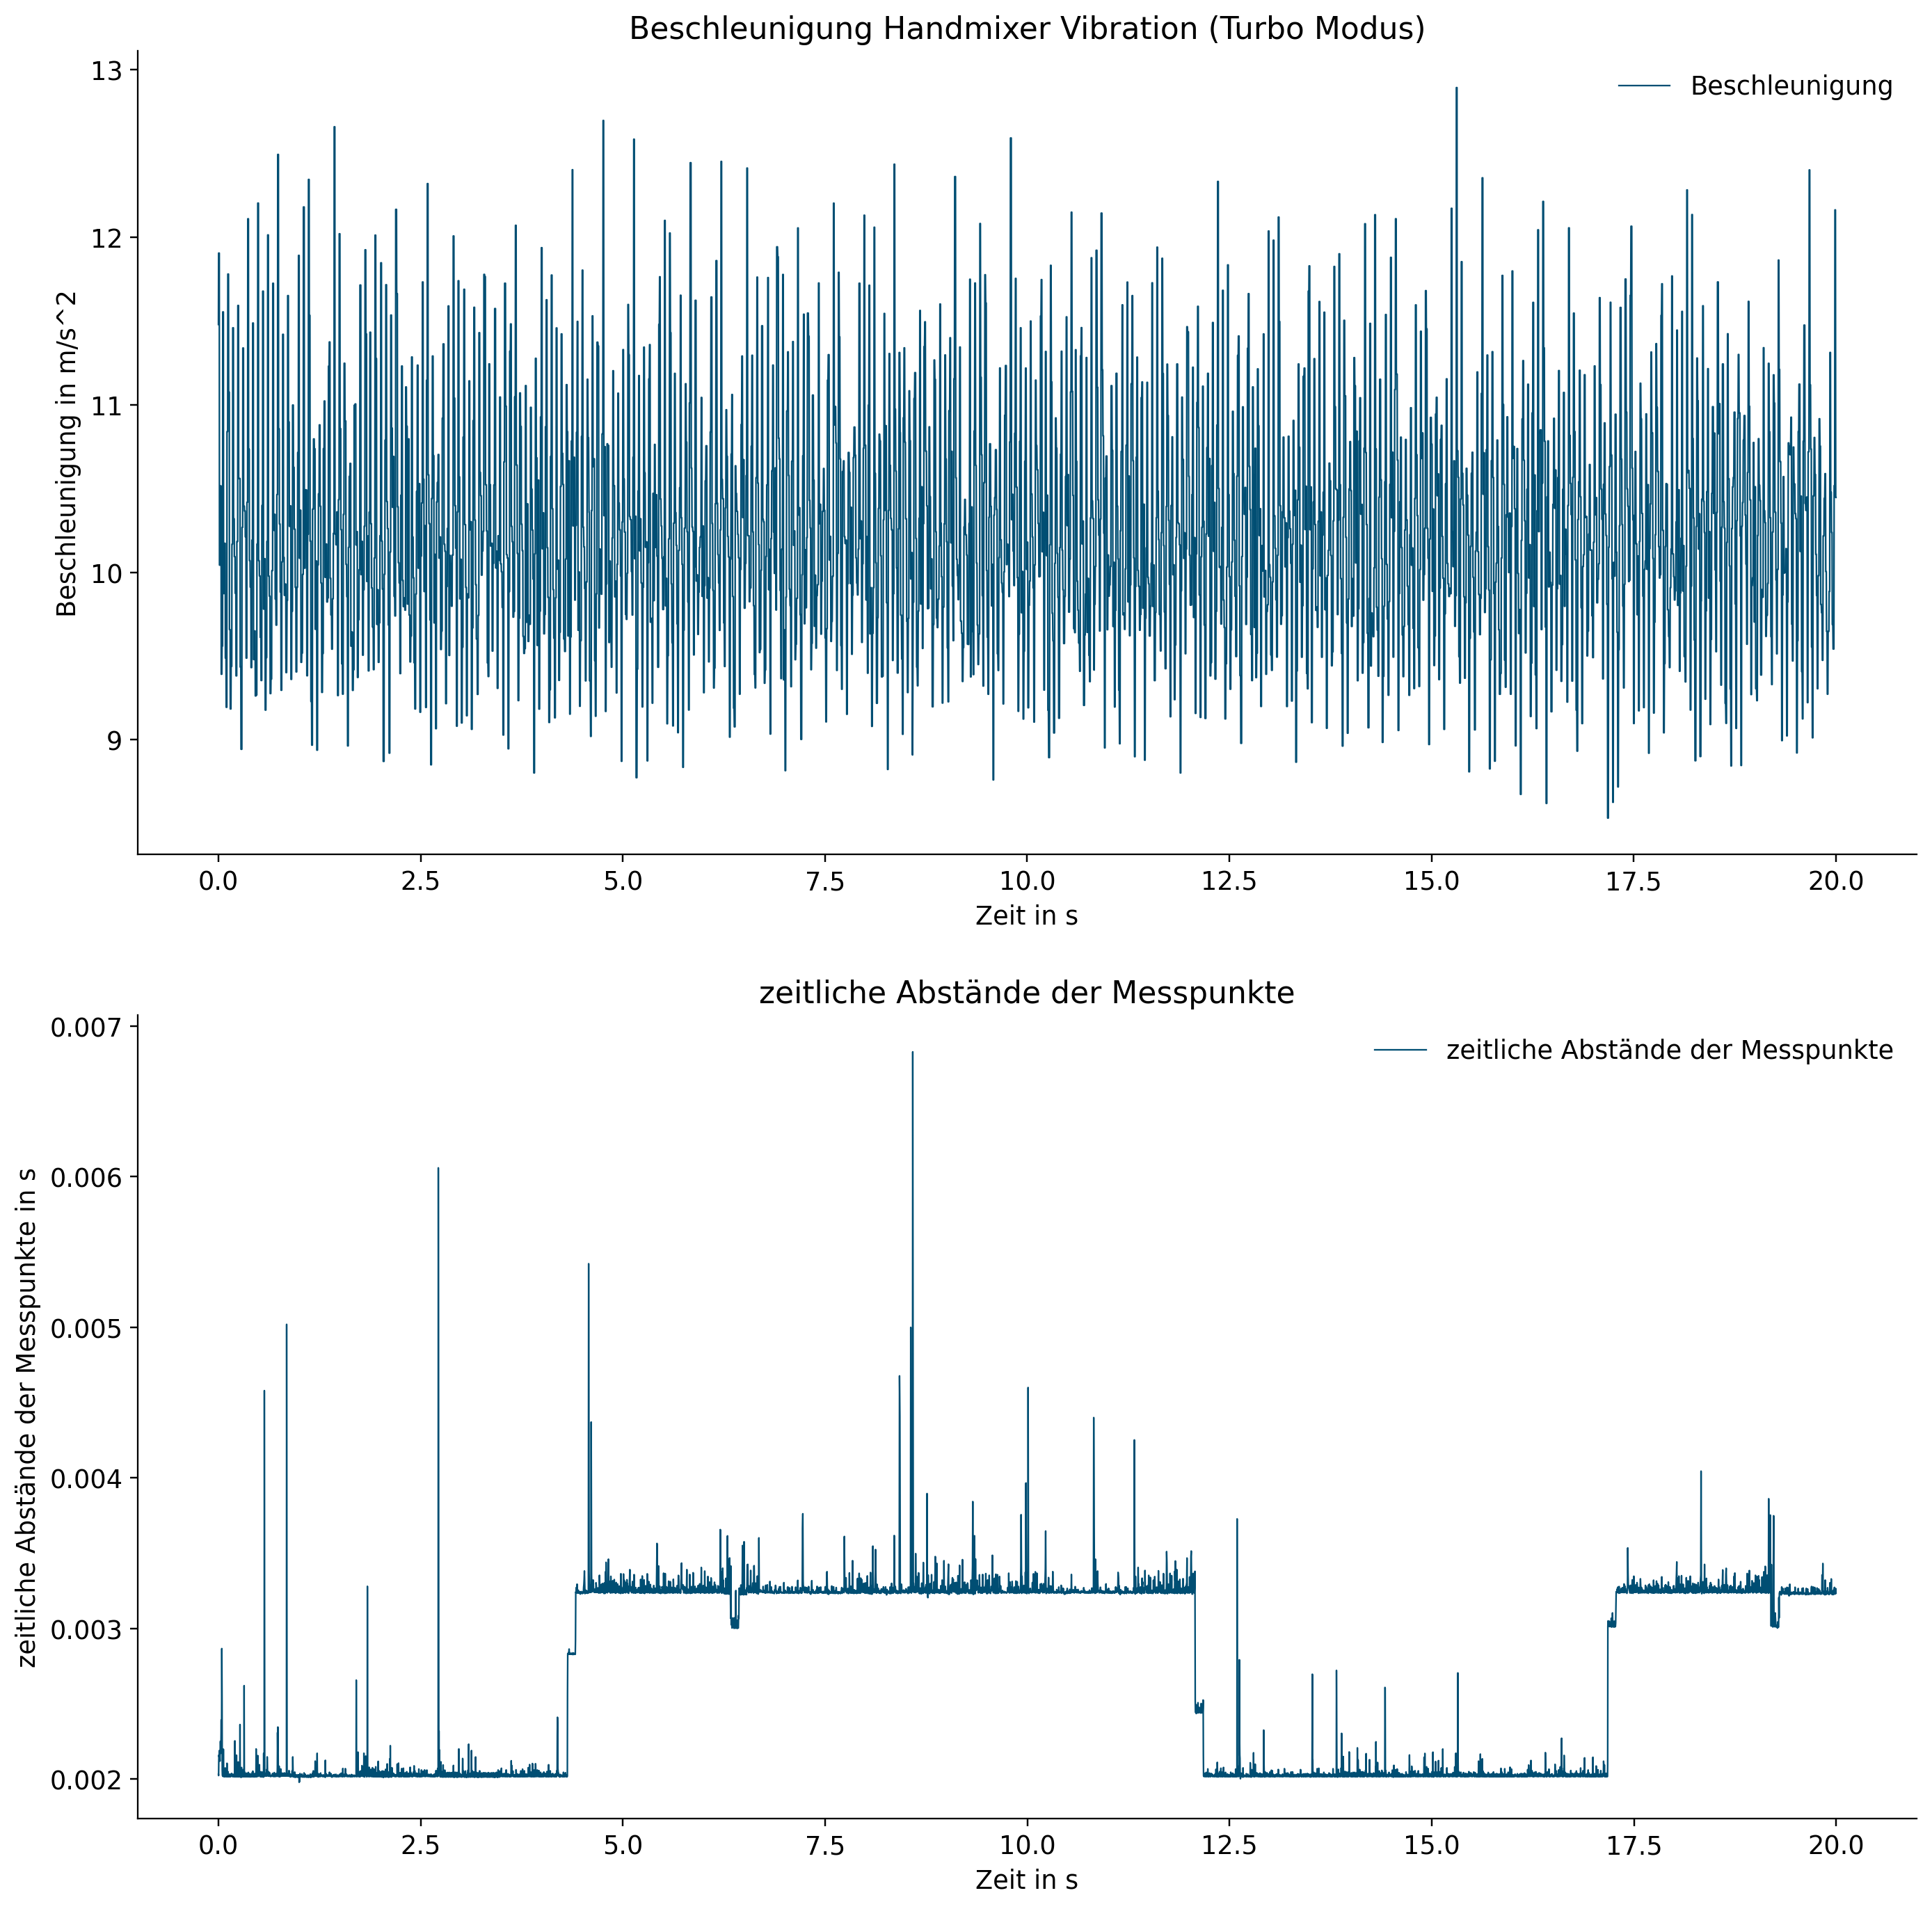

In [15]:
fig,axs = plt.subplots(2,1,figsize=(15, 15))

# Plot für die Beschleunigung erstellen
axs[0].plot(time, acc_mean, label='Beschleunigung')
axs[0].set_xlabel('Zeit in s')
axs[0].set_ylabel('Beschleunigung in m/s^2')
axs[0].set_title('Beschleunigung Handmixer Vibration (Turbo Modus)')
axs[0].legend()

# Liste mit zeitlichen Abständen zwischen den Messpunkten berechnen
time_diff = np.diff(time)
# Plot für die zeitlichen Abstände erstellen
axs[1].plot(time[:-1], time_diff, label='zeitliche Abstände der Messpunkte')
axs[1].set_xlabel('Zeit in s')
axs[1].set_ylabel('zeitliche Abstände der Messpunkte in s')
axs[1].set_title('zeitliche Abstände der Messpunkte')
axs[1].legend()

#### 4. Interpolation der Messwerte



In [16]:
(new_time, new_acc_mean) = interpolation(time, acc_mean)

#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

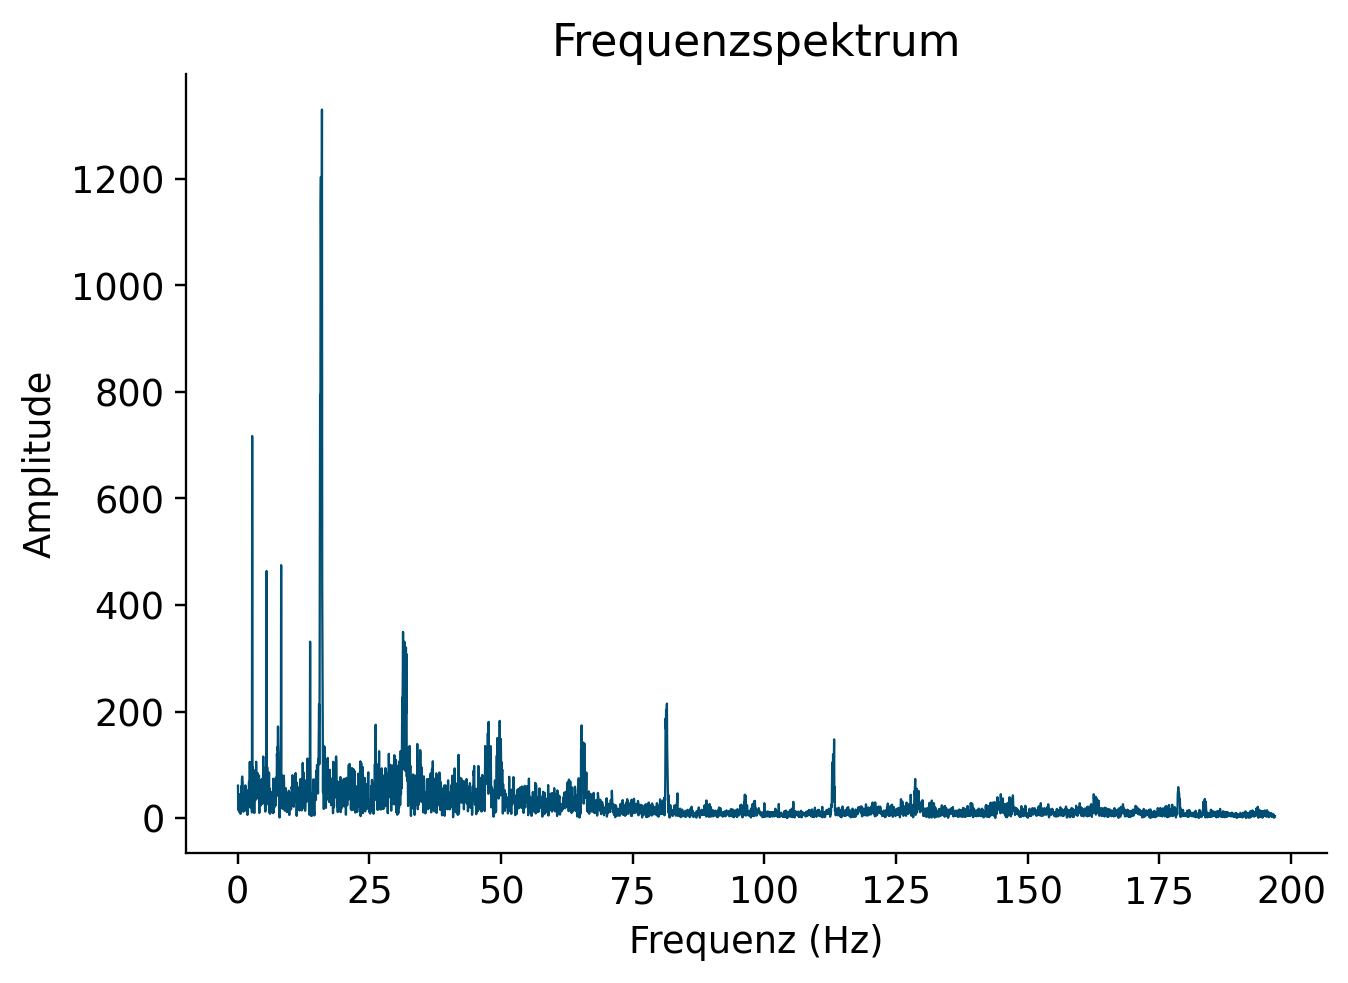

In [18]:
(amplituden, frequenzen) = my_fft(new_acc_mean, new_time)

plt.plot(frequenzen, amplituden)
plt.title('Frequenzspektrum')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Vibration des Handys bei einem Anruf weißt eine maximale Amplitude von 80 bei ca. 50 Hz auf. Bei dem Handmixer beträgt die maximale Amplitude 1300, jedoch nur bei einer Frequenz von 15 Hz. Dies könnte daraufhin deuten, dass das Handy zwar schneller schwingt, die Schwingungen im Handmixer aber stärker sind.
Die Aussagekraft der Ergebnisse ist jedoch nicht 100% genau. Zum einen haben Umgebungsschwingungen (z.B. der PC unter dem Tisch) auf den Beschleunigungssensor eingewirkt. Zum anderen hat sich das Handy wahrscheinlich durch die Vibrationen ein kleines Stück bewegt und den Handmixer konnte ich auch nicht bewegungsfrei festhalten. All diese Bewegungen waren Störgrößen, die die Messungen verunreinigt haben, und somit zu Rauschen oder verfälschten Signalen geführt haben.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Zum einen habe ich in diesem Experiment gemerkt, wie gut ich mittlerweile mit GitLab, dem Pi und JupyterHub umgehen kann. Das Wissen, wie man diese Programme anwenden kann und wie sie einem auch weiterhelfen, konnte ich wieder einmal noch mehr vertiefen. Außerdem konnte ich auch selbstständiger über Python die Funktionen programmieren. Dabei hat mir auch gefallen, wie in diesem Experiment die Hilfestellungen beim Programmieren etwas zurück gegangen sind. So eine praktische Übung habe ich bisher noch in keinem anderen Fach erlebt und ich persönlich finde, dass man durch diesen eigenständigen Umgang mit den Dingen am allerbesten lernt. Ich freue mich auf jeden Fall darauf, GitLab etc. in meinem Berufsleben anwenden zu dürfen!